## **Import necessary libraries**

In [25]:
# General library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Processing image library
import cv2
from scipy.stats import rv_histogram
import concurrent.futures

## **Processing photo background cutting**

In [2]:
def crop_images_without_labels(input_dir, output_dir):
    for root, dirs, files in os.walk(input_dir):
        for dir_name in dirs:
            folder_path = os.path.join(root, dir_name)  # Đường dẫn tới thư mục con
            output_folder_path = os.path.join(output_dir, dir_name)  # Thư mục đầu ra tương ứng

            # Tạo thư mục đầu ra nếu chưa có
            if not os.path.exists(output_folder_path):
                os.makedirs(output_folder_path)

            # Duyệt qua các file ảnh trong thư mục con
            for file_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file_name)
                img = cv2.imread(img_path)

                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Ngưỡng Otsu để cắt hình ảnh
                _, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                hh, ww = thresh.shape[:2]

                # Làm đen hai hàng cuối cùng của ảnh nhị phân
                thresh[hh-3:hh, 0:ww] = 0

                # Tìm giới hạn của các pixel trắng
                white = np.where(thresh == 255)
                if white[0].size > 0:  # Kiểm tra xem có pixel trắng không
                    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

                     # Cắt ảnh gốc theo các giới hạn
                    crop = img[ymin:ymax + 3, xmin:xmax]

                    # Lưu ảnh đã cắt vào thư mục đầu ra, theo tên ảnh gốc
                    output_image_path = os.path.join(output_folder_path, file_name)
                    cv2.imwrite(output_image_path, crop)
                else:
                    # Nếu không có pixel trắng, giữ nguyên ảnh và lưu lại
                    output_image_path = os.path.join(output_folder_path, file_name)
                    cv2.imwrite(output_image_path, img)

    print("Đã hoàn thành việc xử lý background tất cả các ảnh.")


In [3]:
# Cắt background tập train
input_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
output_dir = '/kaggle/working/brain-tumor-mri-dataset/Training'
crop_images_without_labels(input_dir, output_dir)

Đã hoàn thành việc xử lý background tất cả các ảnh.


In [4]:
# Cắt background tập test
input_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
output_dir = '/kaggle/working/brain-tumor-mri-dataset/Testing'
crop_images_without_labels(input_dir, output_dir)

Đã hoàn thành việc xử lý background tất cả các ảnh.


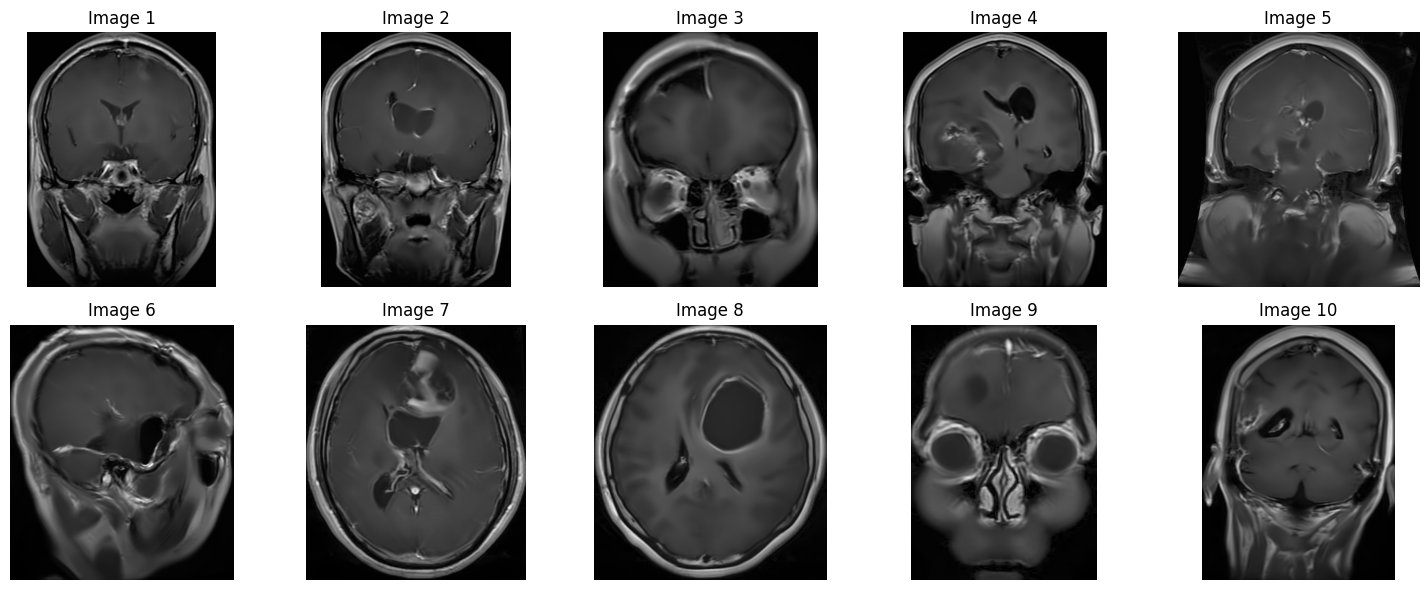

In [35]:
# Đường dẫn tới thư mục chứa các ảnh
folder_path = '/kaggle/working/brain-tumor-mri-equalHist-FilterNoise-dataset/Training/glioma/'

# Lấy danh sách tất cả các tệp ảnh trong thư mục
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Chọn 10 ảnh đầu tiên (hoặc bất kỳ số ảnh nào bạn muốn)
num_images = 20
selected_images = image_files[:num_images]

# Tạo một figure với 10 subplots (2 hàng, 5 cột)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Vẽ từng ảnh vào mỗi subplot
for i, ax in enumerate(axes.flat):
    img_path = os.path.join(folder_path, selected_images[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Đảm bảo ảnh có màu đúng
    ax.imshow(img)
    ax.axis('off')  # Tắt trục
    ax.set_title(f"Image {i+1}")

# Hiển thị toàn bộ figure
plt.tight_layout()
plt.show()

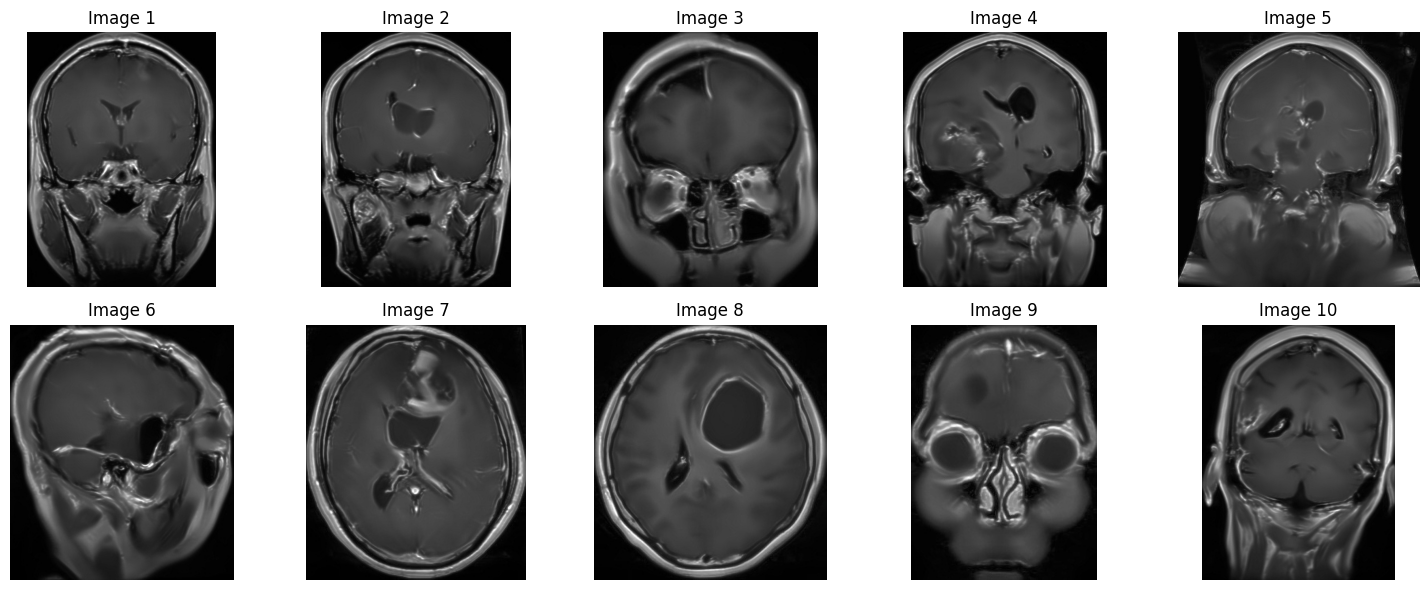

In [41]:
# Đường dẫn tới thư mục chứa các ảnh
folder_path = '/kaggle/working/brain-tumor-mri-equalHist-FilterNoise-Edges-dataset/Training/glioma/'

# Lấy danh sách tất cả các tệp ảnh trong thư mục
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Chọn 10 ảnh đầu tiên (hoặc bất kỳ số ảnh nào bạn muốn)
num_images = 20
selected_images = image_files[:num_images]

# Tạo một figure với 10 subplots (2 hàng, 5 cột)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Vẽ từng ảnh vào mỗi subplot
for i, ax in enumerate(axes.flat):
    img_path = os.path.join(folder_path, selected_images[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Đảm bảo ảnh có màu đúng
    ax.imshow(img)
    ax.axis('off')  # Tắt trục
    ax.set_title(f"Image {i+1}")

# Hiển thị toàn bộ figure
plt.tight_layout()
plt.show()

## **Normalize the image histogramm**

In [7]:
def compute_average_histogram(image_folder, bins=256):
    histograms = []
    for file_name in os.listdir(image_folder):
        file_path = os.path.join(image_folder, file_name)
        if file_name.endswith(('.jpg')):
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                hist, _ = np.histogram(image, bins=bins, range=(0, 256), density=True)
                histograms.append(hist)
    # Tính histogram trung bình
    avg_histogram = np.mean(histograms, axis=0)
    return avg_histogram

In [8]:
def histogram_matching(image, source_hist, target_hist, bins=256):
    # Tính cdf của source và target
    source_cdf = np.cumsum(source_hist)
    target_cdf = np.cumsum(target_hist)
    
    # Mapping từ source -> target
    mapping = np.interp(source_cdf, target_cdf, np.linspace(0, 255, bins))
    
    # Áp dụng mapping
    matched_image = np.interp(image.flatten(), np.linspace(0, 255, bins), mapping)
    return matched_image.reshape(image.shape).astype(np.uint8)

In [9]:
def normalize_images_to_average_histogram(input_folder, output_folder, bins=256):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Duyệt qua tất cả các thư mục con trong thư mục đầu vào
    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        output_category_path = os.path.join(output_folder, category)
        
        if os.path.isdir(category_path):
            # Tạo thư mục con tương ứng trong thư mục đầu ra
            if not os.path.exists(output_category_path):
                os.makedirs(output_category_path)
            
            # Tính histogram trung bình cho tất cả các ảnh trong thư mục category
            avg_histogram = compute_average_histogram(category_path, bins=bins)
            
            # Duyệt qua từng ảnh trong thư mục category
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                if file_name.endswith(('.jpg')):
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                    # Tính histogram hiện tại của hình ảnh
                    hist, _ = np.histogram(image, bins=bins, range=(0, 256), density=True)
                    
                    # Áp dụng Histogram Matching
                    normalized_image = histogram_matching(image, hist, avg_histogram, bins=bins)
                    
                    # Lưu hình ảnh đã chuẩn hóa vào thư mục đầu ra
                    output_image_path = os.path.join(output_category_path, file_name)
                    cv2.imwrite(output_image_path, normalized_image)

In [10]:
# Chuẩn hóa Hitogram trên tập Train
input_folder = "/kaggle/working/brain-tumor-mri-dataset/Training"
output_folder = "/kaggle/working/brain-tumor-mri-equalHist-dataset/Training"

normalize_images_to_average_histogram(input_folder, output_folder)

In [11]:
# Chuẩn hóa Hitogram trên tập Test
input_folder = "/kaggle/working/brain-tumor-mri-dataset/Testing"
output_folder = "/kaggle/working/brain-tumor-mri-equalHist-dataset/Testing"

normalize_images_to_average_histogram(input_folder, output_folder)

## **Filter image noise**

In [30]:
def process_image(file_path, output_path, h=10, templateWindowSize=7, searchWindowSize=21):
    img = cv2.imread(file_path)
    denoised_img = cv2.fastNlMeansDenoisingColored(img, None, h, templateWindowSize, searchWindowSize)
    cv2.imwrite(output_path, denoised_img)

In [28]:
def process_images_denoising(input_folder, output_folder, h=10, templateWindowSize=7, searchWindowSize=21):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        output_category_path = os.path.join(output_folder, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        
        # Sử dụng parallel processing để xử lý ảnh nhanh hơn
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = []
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                output_image_path = os.path.join(output_category_path, file_name)
                futures.append(executor.submit(process_image, file_path, output_image_path, h, templateWindowSize, searchWindowSize))

            # Chờ tất cả các công việc hoàn thành
            for future in concurrent.futures.as_completed(futures):
                future.result()

In [31]:
# Lọc nhiễu trên tập train
input_folder = '/kaggle/working/brain-tumor-mri-equalHist-dataset/Training'  
output_folder = '/kaggle/working/brain-tumor-mri-equalHist-FilterNoise-dataset/Training'

# Áp dụng lọc nhiễu cho tất cả các ảnh
process_images_denoising(input_folder, output_folder)

In [33]:
# Lọc nhiễu trên tập test
input_folder = '/kaggle/working/brain-tumor-mri-equalHist-dataset/Testing'  
output_folder = '/kaggle/working/brain-tumor-mri-equalHist-FilterNoise-dataset/Testing'

# Áp dụng lọc nhiễu cho tất cả các ảnh
process_images_denoising(input_folder, output_folder)

## **Highlight edges**

In [38]:
def enhance_edges(input_folder, output_folder, ksize=5, sigma=1.0):
    # Kiểm tra nếu thư mục đầu ra không tồn tại thì tạo mới
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Duyệt qua từng thư mục con trong thư mục đầu vào
    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        # Kiểm tra nếu đây là thư mục con
        if os.path.isdir(category_path):
            
            # Tạo thư mục con tương ứng trong thư mục đầu ra nếu chưa tồn tại
            output_category_path = os.path.join(output_folder, category)
            if not os.path.exists(output_category_path):
                os.makedirs(output_category_path)

            # Duyệt qua các tệp trong thư mục con
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)

                if file_path.lower().endswith('.jpg'):

                    img = cv2.imread(file_path)
                    
                    # Bước 1: Chuyển ảnh sang ảnh xám
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Bước 2: Áp dụng bộ lọc Gaussian để làm mượt ảnh
                    blurred_img = cv2.GaussianBlur(gray_img, (ksize, ksize), sigma)

                    # Bước 3: Áp dụng Laplacian để phát hiện biên
                    laplacian_img = cv2.Laplacian(blurred_img, cv2.CV_64F)

                    # Bước 4: Chuyển ảnh Laplacian sang kiểu uint8 để hiển thị và xử lý
                    laplacian_img = cv2.convertScaleAbs(laplacian_img)

                    # Bước 5: Cộng ảnh Laplacian vào ảnh gốc để làm nổi bật biên
                    enhanced_img = cv2.addWeighted(img, 1, cv2.cvtColor(laplacian_img, cv2.COLOR_GRAY2BGR), 1, 0)

                    # Lưu ảnh đã xử lý vào thư mục con tương ứng
                    output_file_path = os.path.join(output_category_path, filename)
                    cv2.imwrite(output_file_path, enhanced_img)


In [39]:
# Phát hiện biên trên train
input_image_path = '/kaggle/working/brain-tumor-mri-equalHist-FilterNoise-dataset/Training' 
output_image_path = '/kaggle/working/brain-tumor-mri-equalHist-FilterNoise-Edges-dataset/Training' 

enhance_edges(input_image_path, output_image_path)

In [40]:
# Phát hiện biên trên test
input_image_path = '/kaggle/working/brain-tumor-mri-equalHist-FilterNoise-dataset/Testing' 
output_image_path = '/kaggle/working/brain-tumor-mri-equalHist-FilterNoise-Edges-dataset/Testing' 

enhance_edges(input_image_path, output_image_path)

In [44]:
import os
import shutil

def delete_folder(folder_path):
    try:
        # Kiểm tra nếu thư mục tồn tại
        if os.path.exists(folder_path):
            # Xóa toàn bộ thư mục và nội dung
            shutil.rmtree(folder_path)
            print(f"Đã xóa thư mục: {folder_path}")
        else:
            print(f"Thư mục không tồn tại: {folder_path}")
    except Exception as e:
        print(f"Lỗi khi xóa thư mục: {e}")

# Thay đổi đường dẫn thư mục cần xóa
folder_to_delete = "/kaggle/working/brain-tumor-mri-equalHist-dataset"
delete_folder(folder_to_delete)


Đã xóa thư mục: /kaggle/working/brain-tumor-mri-equalHist-dataset
